In [150]:
# Useful starting lines
%matplotlib inline
import importlib.util
import implementations
import numpy as np
import matplotlib.pyplot as plt
from proj1_helpers import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [151]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)


## Do your thing crazy machine learning thing here :) ...

## Generate predictions and save ouput in csv format for submission:

In [152]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [153]:
# normalize datas
tX_test = implementations.normalize(tX_test)
tX = implementations.normalize(tX)
y[y==-1]=0  


In [154]:
# boson proportion in train datas
prop=len(y[y==0])/len(y)
print(prop)
# the proportion being close to 0.5, we can say that F1-score will not be as important as if the set was really imbalanced.

0.657332


In [155]:
#apply method
def get_w_loss(y,x,method,initial_w=0,max_iters=10,gamma=0.00000005,threshold=1e-08,logs=False,batch_size=1,lambda_=0.005, store=False):
    """applies the algorithm described by <method>. by default as the awaited behaviour for the project, but offers some possible enhancements (batch_size,threshold, logs, store)
    Args:
        y (numpy.ndarray): An array with shape (n,1)
        tx (numpy.ndarray): An array with shape (n,m)
        method (int): 1 -> least_squares_GD*                
                      2 -> stochastic_gradient_descent*
                      3 -> least_squares
                      4 -> ridge_regression
                      5 -> logistic_regression_gradient_descent*
                      6 -> reg_logistic_regression*
        * this algorithm is an iterative descent
        initial_w (Union[float, numpy.ndarray], optional): if a int is set w will start with an array. Defaults to 0.
        max_iters (int, optional): number of iterations (only for descent algorithms). Defaults to 10.
        gamma (float, optional): descent scale factor (only for descent algorithms). Defaults to 0.00000005.
        threshold (float, optional): threshold to prevent divergence in case of linear separability (I assume). Defaults to 1e-08.
        log (bool, optional): if True step by step logs are displayed (only for descent algorithms). Defaults to False.
        batch_size (int, optional): size of the sample on which to compute the partial gradient for stochastic gradient descent algorithm. Defaults to 1.
        lambda_ (float, optional): regularization factor with good values allows to limit overfitting and underfitting (only for ridge_regression and reg_logistic_regression). Defaults to 0.005.
        store (bool, optional): [description]. Defaults to False.
    Returns:
        w (numpy.ndarray): ndarray with shape (n_iters,m) if store and if the method is a descent, else shape(m,1) 
        loss (Union[numpy.ndarray, float]): ndarray with shape (n_iters,) if store and if the method is a descent, else float
    :raises ValueError: if method is not <6
    """
    if(method==1):
        return implementations.least_squares_GD(y,x, initial_w, max_iters, gamma, logs,store)
    elif(method==2): 
        return implementations.stochastic_gradient_descent(y,x, initial_w, max_iters, gamma, batch_size, logs,store)
    elif(method==3):
        return implementations.least_squares(y,x)
    elif(method==4):
        return implementations.ridge_regression(y,x, lambda_=lambda_)
    elif(method==5):
        return implementations.logistic_regression_gradient_descent(y,x,initial_w,max_iters,gamma,threshold,logs,store)
    elif(method==6):
        return implementations.reg_logistic_regression(y,x,initial_w,max_iters,gamma,threshold,logs,store,lambda_)
    else:
        return ValueError


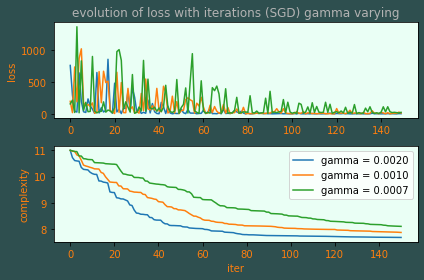

In [158]:
'''
We try to visualise the influance of gamma on the stochastic gradient descent algorithm.
'''
fig, axs = plt.subplots(2,1,facecolor=(.18, .31, .31))
gammas=[]
for i in range(1,4):
    gamma=1/(500*i)
    gammas.append(gamma) 
    weights, losses = get_w_loss(y,implementations.build_poly(tX,4),2,1,max_iters=150,gamma=gamma,store=True)
    axs[0].plot(losses)
    axs[1].plot([np.linalg.norm(item) for item in weights])
legend = list(map(lambda x: "gamma = {:.4f}".format(x),gammas))
plt.legend(legend)
axs[0].set_facecolor('#eafff5')
axs[1].set_facecolor('#eafff5')
axs[0].set_title('evolution of loss with iterations (SGD) gamma varying', color='0.7')
axs[0].set_ylabel("loss", color='tab:orange')
axs[1].set_ylabel("complexity", color='tab:orange')
axs[1].set_xlabel("iter",color='tab:orange')
axs[0].tick_params(labelcolor='tab:orange')
axs[1].tick_params(labelcolor='tab:orange')
plt.savefig("../visualisations/loss_complexity_vs_iter_sGD.png")
plt.tight_layout()




In [159]:
'''
Is feature expension useful ? 
'''
def Feature_Expension_Benchmark( degree,k_fold=10):
    """Here we try to assess the utility of feature expension
    """
    method=1
    indices=implementations.build_k_indices(len(y),k_fold)
    F1s=[]
    accuracies=[]
    for i in range(1, degree):
        enhanced_tX = implementations.build_poly(tX, i)
        print("{}.1 : Train test split".format(i))
        x_train, y_train, x_test, y_test=implementations.cross_validation_split(y,enhanced_tX,indices,0)
        y_test[y_test==0]=-1
        #x_test = np.c_[np.ones((y_test.shape[0], 1)), x_test]
        print("{}.2 : Compute gradient descent".format(i))
        w, loss_tr = get_w_loss(y_train,x_train,method,gamma=0.0005,max_iters=2000)
        y_pred = predict_labels(w,x_test)
        print("{}.3 : Compute stats".format(i))
        matches = [i for i, j in zip(y_pred, y_test) if i == j]  
        accuracies.append( len(matches)/len(y_test))
        F1s.append( implementations.f1_score(y_test,y_pred))
    return F1s, accuracies
F1s, accuracies= Feature_Expension_Benchmark( 10,k_fold=10)






1.1 : Train test split
1.2 : Compute gradient descent
1.3 : Compute stats
2.1 : Train test split
2.2 : Compute gradient descent
2.3 : Compute stats
3.1 : Train test split
3.2 : Compute gradient descent
3.3 : Compute stats
4.1 : Train test split
4.2 : Compute gradient descent
4.3 : Compute stats
5.1 : Train test split
5.2 : Compute gradient descent
5.3 : Compute stats
6.1 : Train test split
6.2 : Compute gradient descent
6.3 : Compute stats
7.1 : Train test split
7.2 : Compute gradient descent
7.3 : Compute stats
8.1 : Train test split
8.2 : Compute gradient descent
8.3 : Compute stats
9.1 : Train test split
9.2 : Compute gradient descent
9.3 : Compute stats


[0.14773295966369732, 0.18074389771406432, 0.19433275895079458, 0.21601941747572817, 0.24746926970354302, 0.2724246671338472, 0.28982774873596706, 0.30356992860142795, 0.3167989417989418]


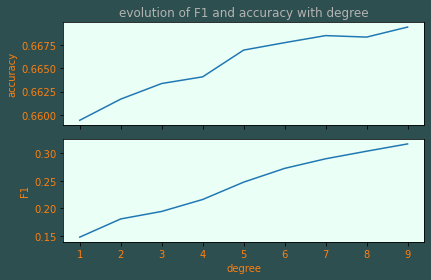

In [160]:
'''last cell results visualization'''
fig, axs = plt.subplots(2,1,facecolor=(.18, .31, .31),sharex=True)
axs[0].plot(accuracies)
axs[1].plot(F1s)
axs[0].set_facecolor('#eafff5')
axs[1].set_facecolor('#eafff5')
axs[0].set_title('evolution of F1 and accuracy with degree', color='0.7')
axs[0].set_ylabel("accuracy", color='tab:orange') 
axs[1].set_ylabel("F1", color='tab:orange')
axs[1].set_xlabel("degree",color='tab:orange')
plt.xticks(range(0,9),range(1,10))
axs[0].tick_params(labelcolor='tab:orange')
axs[1].tick_params(labelcolor='tab:orange')
plt.savefig("../visualisations/degree_influence2.png")
plt.tight_layout()
plt.show()

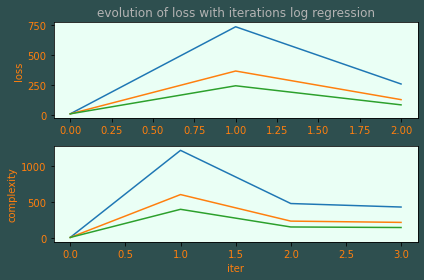

In [164]:
fig, axs = plt.subplots(2,1,facecolor=(.18, .31, .31))
gammas=[]
for i in range(1,4):
    gamma=5/(2000*i)
    gammas.append(gamma)
    weights, losses = get_w_loss(y,implementations.build_poly(tX,4),5,1,max_iters=25,gamma=gamma,store=True)
    axs[0].plot(losses)
    axs[1].plot([np.linalg.norm(item) for item in weights])
legend = list(map(lambda x: "gamma = {:.2f}".format(x),gammas))
axs[0].set_facecolor('#eafff5')
axs[1].set_facecolor('#eafff5')
axs[0].set_title('evolution of loss with iterations log regression', color='0.7')
axs[0].set_ylabel("loss", color='tab:orange')
axs[1].set_ylabel("complexity", color='tab:orange')
axs[1].set_xlabel("iter",color='tab:orange')
axs[0].tick_params(labelcolor='tab:orange')
axs[1].tick_params(labelcolor='tab:orange')
plt.savefig("../visualisations/loss complexity vs iter log gamma varying.png")
plt.tight_layout()


Current iteration=0, loss=7.338452660003367
Current iteration=0, loss=7.338452660003367
Current iteration=0, loss=7.338452660003367
Current iteration=0, loss=7.338452660003367
Current iteration=0, loss=7.338452660003367
Current iteration=0, loss=7.338452660003367


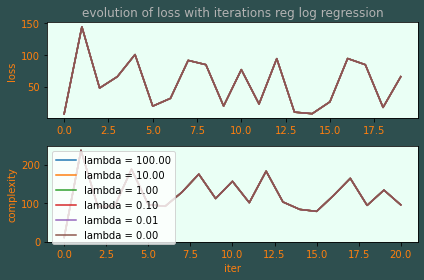

In [166]:
fig, axs = plt.subplots(2,1,facecolor=(.18, .31, .31))

lambdas_=[]
for i in range(1,7):
    lambda_=1000/10**i
    lambdas_.append(lambda_)
    weights, losses = get_w_loss(y,implementations.build_poly(tX,4),6,1,max_iters=20,gamma=0.0005,lambda_=lambda_,store=True,logs=True)
    axs[0].plot(losses)
    axs[1].plot([np.linalg.norm(item) for item in weights])
legend = list(map(lambda x: "lambda = {:.2f}".format(x),lambdas_))
axs[0].set_facecolor('#eafff5')
axs[1].set_facecolor('#eafff5')
axs[0].set_title('evolution of loss with iterations reg log regression', color='0.7')
axs[0].set_ylabel("loss", color='tab:orange')
axs[1].set_ylabel("complexity", color='tab:orange')
axs[1].set_xlabel("iter",color='tab:orange')
axs[0].tick_params(labelcolor='tab:orange')
axs[1].tick_params(labelcolor='tab:orange')
plt.legend(legend)
plt.savefig("../visualisations/loss complexity vs iters reg log lambda varying.png")
plt.tight_layout()


Current iteration=0, loss=7.338452660003367
Current iteration=0, loss=7.338452660003367
Current iteration=0, loss=7.338452660003367


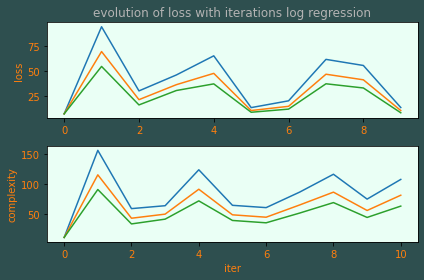

In [167]:
fig, axs = plt.subplots(2,1,facecolor=(.18, .31, .31))
gammas=[]
for i in range(1,4):
    gamma=5/(i*5000+10000)
    gammas.append(gamma)
    weights, losses = get_w_loss(y,implementations.build_poly(tX, 4),6,1,max_iters=10,gamma=gamma,store=True)
    axs[0].plot(losses)
    axs[1].plot([np.linalg.norm(item) for item in weights])
legend = list(map(lambda x: "gamma = {:.2f}".format(x),gammas))
axs[0].set_facecolor('#eafff5')
axs[1].set_facecolor('#eafff5')
axs[0].set_title('evolution of loss with iterations log regression', color='0.7')
axs[0].set_ylabel("loss", color='tab:orange')
axs[1].set_ylabel("complexity", color='tab:orange')
axs[1].set_xlabel("iter",color='tab:orange')
axs[0].tick_params(labelcolor='tab:orange')
axs[1].tick_params(labelcolor='tab:orange')
plt.savefig("../visualisations/loss complexity vs iter reg log.png")
plt.tight_layout()


In [177]:
def I_do_it_all_and_I_try_to_do_it_good_REG_LOG_REG( degree, lambdas_,k_fold=10):
    """Here we try to combine all the work we did on this project in one function (We don't know the complexity but it might be very high...)
    The goal is to be able to replicate the submission process using a cross validation.
    Args:
        degree (int): must be superior to 1, degree to use for the feature expensions.
        lambdas_ (list): list of the lambdas to use, single varying hyper-parameter here
         k_fold (int, optional): number of folds to use for the cross validation, 10 is recommended. Defaults to 10.
    Returns:
        (np.ndarray,float,float,float,float,float,int,int,int,int):  best_model, losses_tr_best, losses_te_best, best_lambda, best_accuracy, best_F1, best_TP, best_TN, best_FP, best_FN
    """
    method=6
    indices=implementations.build_k_indices(len(y),k_fold)
    enhanced_tX = implementations.build_poly(tX, degree)
    best_heuristique = best_accuracy = best_TP = best_TS = best_lambda = best_losses_tr = best_losses_te = 0
    best_model=[]
    print("1 : Train test split")
    x_train, y_train, x_test, y_test=implementations.cross_validation_split(y,enhanced_tX,indices,0)
    print(x_train.shape)
    print(x_test.shape)
    print(y_train.shape)
    print(y_test .shape)
    y_test[y_test==0]=-1
    #x_test = np.c_[np.ones((y_test.shape[0], 1)), x_test]
    print("2 : Compute regularized logistic regression")
    for lambda_ in lambdas_:
        
        w, loss_tr = implementations.get_w_loss(y_train,x_train,method,gamma=0.005,max_iters=100,lambda_=lambda_)

        print("3 : Predict using generated model with {}".format(lambda_))
        y_pred = predict_labels(w,x_test)
        print("4 : Compute stats with {}".format(lambda_))
        matches = [i for i, j in zip(y_pred, y_test) if i == j]  
        accuracy = len(matches)/len(y_test)
        F1 = implementations.f1_score(y_test,y_pred)
        print(F1)
        if (2*accuracy + F1 > best_heuristique):  # As the set seems not to much unbalanced I give more importance to accuracy than F1.
            best_model = w
            best_TP, best_TN, best_FP, best_FN,precision, recall = implementations.stats(y_test,y_pred)
            best_lambda= lambda_
            best_F1 = F1
            best_accuracy = accuracy
            loss_te_best = loss_te=implementations.calculate_loss(y_test,x_test,w,lambda_)
            loss_tr_best= loss_tr
    print("5 : Generate the submission")
    implementations.submit(_,tX_test,best_model,ids_test,method,degree)
    return best_model, losses_tr_best, losses_te_best, best_lambda, best_accuracy, best_F1, best_TP, best_TN, best_FP, best_FN

lambdas_=list(map(lambda x: 5/(10**(x[0])), enumerate([1]*5)))
best_model, losses_tr_best, losses_te_best, best_lambda, best_accuracy, best_F1, best_TP, best_TN, best_FP, best_FN = I_do_it_all_and_I_try_to_do_it_good_REG_LOG_REG(4, lambdas_)



1 : Train test split
(225000, 121)
(25000, 121)
(225000,)
(25000,)
2 : Compute regularized logistic regression
3 : Predict using generated model with 5.0


ValueError: shapes (25000,121) and (101,122) not aligned: 121 (dim 1) != 101 (dim 0)

In [173]:
    # values completion on lacking features using least squares.
    y, tX, ids = load_csv_data(DATA_TRAIN_PATH) # reloading to lose normalisation
    _, tX_test, ids_test = load_csv_data(DATA_TEST_PATH) 
    tX_completed = implementations.Datas_completion_lacking_values_predicted(tX)
    tX_completed = implementations.normalize(tX_completed)
    tX_test = implementations.normalize(tX_test)
    tX = implementations.normalize(tX)
    y[y==-1]=0

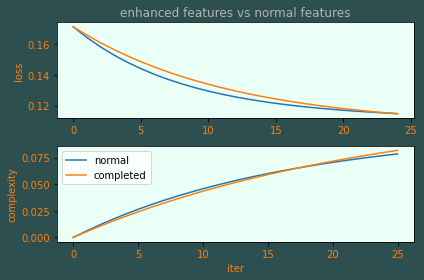

In [176]:
# Test feature correction using least squares to give values to features lacking some values.
# It does not seem to change anything. 
enhanced_completed_tX= implementations.build_poly(tX_completed,4)
enhanced_tX = implementations.build_poly(tX,4)
w_completed, loss_completed = implementations.get_w_loss(y, enhanced_completed_tX, 1, gamma=0.005, max_iters = 25, store=True)
w, loss = implementations.get_w_loss(y, enhanced_tX, 1, max_iters=25, gamma=0.005, store=True)

fig, axs = plt.subplots(2,1,facecolor=(.18, .31, .31))
axs[0].plot(loss)
axs[0].plot(loss_completed)
axs[1].plot([np.linalg.norm(item) for item in w])
axs[1].plot([np.linalg.norm(item) for item in w_completed])
axs[0].set_facecolor('#eafff5')
axs[1].set_facecolor('#eafff5')
axs[0].set_title('enhanced features vs normal features', color='0.7')
axs[0].set_ylabel("loss", color='tab:orange')
axs[1].set_ylabel("complexity", color='tab:orange')
axs[1].set_xlabel("iter",color='tab:orange')
axs[0].tick_params(labelcolor='tab:orange')
axs[1].tick_params(labelcolor='tab:orange')
plt.legend(["normal","completed"])
plt.savefig("../visualisations/completed_vs_normal_features.png")
plt.tight_layout()




In [148]:
# Test feature correction using linear regression to give values to features lacking some values.
# we now try to observe a difference in accuracy or F1 

def Feature_Completion_Benchmark( k_fold = 10):
    """Here we try to assess the utility of the feature completion (trying to put a value on each -999 value using least squares)
    """
    method=1
    indices=implementations.build_k_indices(len(y),k_fold)
    enhanced_completed_tX = implementations.build_poly(tX_completed,4)
    enhanced_tX = implementations.build_poly(tX, 4)
    print("1 : Train test split")
    x_train, y_train, x_test, y_test=implementations.cross_validation_split(y,enhanced_tX,indices,0)
    x_train_completed, y_train_completed, x_test_completed, y_test_completed=implementations.cross_validation_split(y,enhanced_completed_tX,indices,0)
    y_test[y_test==0]=-1
    #x_test = np.c_[np.ones((y_test.shape[0], 1)), x_test]
    print("2 : Compute gradient descent")
    w, loss_tr = get_w_loss(y_train,x_train,method,gamma=0.05,max_iters=200)
    w_completed, loss_tr_completed = get_w_loss(y_train,x_train_completed,method,gamma=0.05,max_iters=200)
    y_pred = predict_labels(w,x_test)
    y_pred_completed = predict_labels(w_completed,x_test_completed)
    print("4 : Compute stats")
    matches = [i for i, j in zip(y_pred, y_test) if i == j]  
    accuracy = len(matches)/len(y_test) 
    matches = [i for i, j in zip(y_pred_completed, y_test) if i == j]  
    accuracy_completed = len(matches)/len(y_test) 
    F1=implementations.f1_score(y_test,y_pred)
    F1_completed=implementations.f1_score(y_test,y_pred_completed)
    print("no completion : accuracy = {}, F1 = {}, with completion : accuracy = {}, F1 = {}".format(accuracy, F1, accuracy_completed, F1_completed))
    return F1, accuracy,F1_completed , accuracy_completed
F1s, accuracies, F1s_completed, accuracies_completed= Feature_Completion_Benchmark()




1 : Train test split
2 : Compute gradient descent
4 : Compute stats
no completion : accuracy = 0.68412, F1 = 0.42936628369101815, with completion : accuracy = 0.70036, F1 = 0.46618684529323734


In [16]:
OUTPUT_PATH = '../data/submission.csv'

#submit(_, tX_test, w, ids_test, method, degree)
